In [13]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Connect to a GPU
device

device(type='cuda')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
train_data = datasets.MNIST(root='/content/drive/MyDrive/UOM/MNIST', train=True, download=True, transform=ToTensor())
test_data = datasets.MNIST(root='/content/drive/MyDrive/UOM/MNIST', train=False, download=True, transform=ToTensor())

In [38]:
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/UOM/MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/UOM/MNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


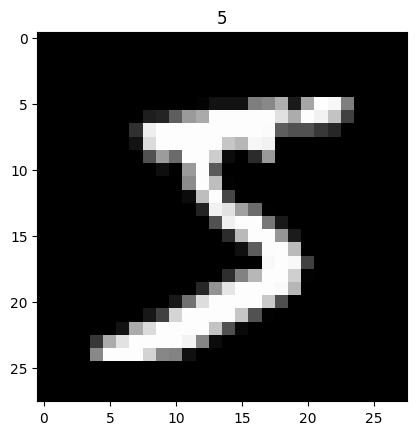

In [39]:
plt.imshow(train_data[0][0].squeeze(), cmap='gray')# Show one image in gray
plt.title(train_data[0][1])
plt.show()

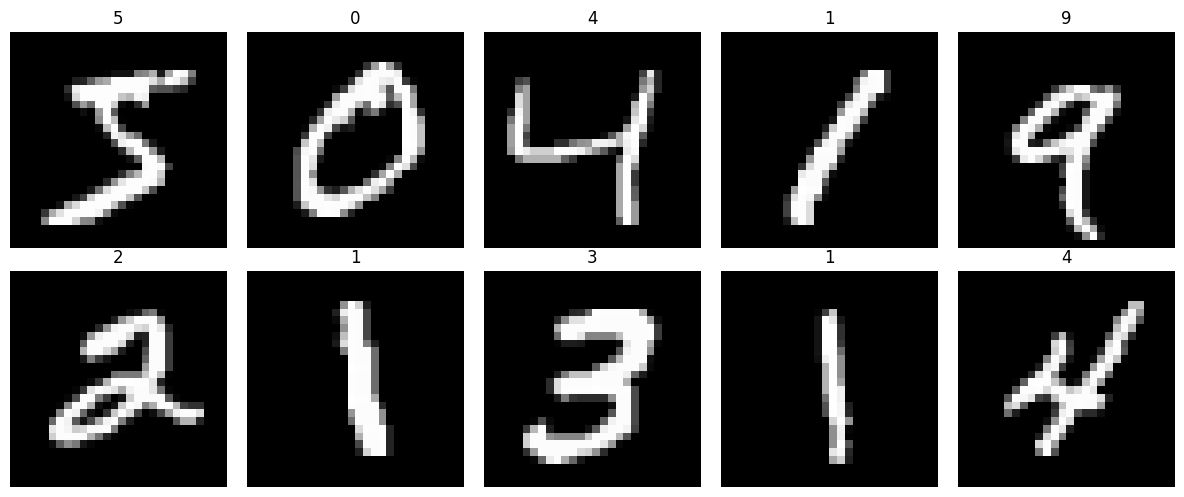

In [40]:
num_images = 10
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

axes = axes.flatten()

for i in range(num_images):
    axes[i].imshow(train_data[i][0].squeeze(), cmap='gray')
    axes[i].set_title(train_data[i][1])
    axes[i].axis('off')  # Hide axis ticks

plt.tight_layout()
plt.show()

In [41]:
from torch.utils.data import DataLoader

# This import the data as mini batches
train_loader = DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False, num_workers=1)

## Neural Network Creation

In [42]:
import torch.nn as nn

In [43]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(
            in_channels = 1, # because it is only gray scale...we don't need RGB
            out_channels=16, # This is K
            kernel_size=5,
            stride=1,
            padding=2,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(
            in_channels = 16, # because it is only gray scale...we don't have RGB
            out_channels=32, # This is K
            kernel_size=5,
            stride=1,
            padding=2,
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    #Fully connected layer
    self.out = nn.Linear(32*7*7, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

      #Reshape
    x = x.view(x.size(0), -1) # Flatten
    output = self.out(x)

    return output, x

In [44]:
cnn = CNN()
print(cnn)


CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [45]:
from torch import optim
from torch.autograd import Variable

In [46]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)

In [47]:
num_epoch = 10

def train(num_epoch, cnn, train_loader, test_loader):
  cnn.train()

  total_step = len(train_loader)

  for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(train_loader):
      images = Variable(images)
      labels = Variable(labels)

      optimizer.zero_grad()
      outputs, _ = cnn(images)
      loss = loss_function(outputs, labels)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if (i+1) % 100==0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epoch, i+1, total_step, loss.item()))
        pass
      pass
    pass

train(num_epoch,cnn,train_loader,test_loader)

Epoch [1/10], Step [100/600], Loss: 0.1547
Epoch [1/10], Step [200/600], Loss: 0.0952
Epoch [1/10], Step [300/600], Loss: 0.1000
Epoch [1/10], Step [400/600], Loss: 0.1270
Epoch [1/10], Step [500/600], Loss: 0.0775
Epoch [1/10], Step [600/600], Loss: 0.1085
Epoch [2/10], Step [100/600], Loss: 0.0565
Epoch [2/10], Step [200/600], Loss: 0.0216
Epoch [2/10], Step [300/600], Loss: 0.0262
Epoch [2/10], Step [400/600], Loss: 0.1172
Epoch [2/10], Step [500/600], Loss: 0.0489
Epoch [2/10], Step [600/600], Loss: 0.0515
Epoch [3/10], Step [100/600], Loss: 0.1001
Epoch [3/10], Step [200/600], Loss: 0.0292
Epoch [3/10], Step [300/600], Loss: 0.0469
Epoch [3/10], Step [400/600], Loss: 0.0361
Epoch [3/10], Step [500/600], Loss: 0.0584
Epoch [3/10], Step [600/600], Loss: 0.0441
Epoch [4/10], Step [100/600], Loss: 0.0431
Epoch [4/10], Step [200/600], Loss: 0.0195
Epoch [4/10], Step [300/600], Loss: 0.0595
Epoch [4/10], Step [400/600], Loss: 0.0071
Epoch [4/10], Step [500/600], Loss: 0.0460
Epoch [4/10

In [53]:
def test():
  cnn.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      test_output, last_layer = cnn(images)
      pred_y = torch.max(test_output, 1)[1].data.squeeze()
      accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
      pass
    print('Test Accuracy: %.2f'%accuracy)
    pass
  pass
test()

Test Accuracy: 0.97
